# Convolutional neural networks

In the previous unit we learned how to define a generic multi-layered neural network. In this unit we will learn about **Convolutional Neural Networks (CNNs)**, which are specifically designed for computer vision.

Computer vision is different from generic classification, because when we are trying to find a certain object in the picture, we are scanning the image looking for some specific **patterns** and their combinations. For example, when looking for a cat, we first may look for horizontal lines, which can form whiskers, and then certain combination of whiskers can tell us that it is actually a picture of a cat. The position and presence of certain patterns are important. 

To extract patterns, we will use the notion of **convolutional filters**. But first, let us load all dependencies and functions that we have defined in the previous units. We will also import `tfcv`, a helper library that contain some useful functions that we do not want to define inside this notebook to keep the code short and clean. 

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# Pre-fetch the data when running in sandbox environment
!mkdir -p ~/.keras/datasets
!wget -P ~/.keras/datasets -q https://github.com/MicrosoftDocs/tensorflowfundamentals/raw/main/data/mnist.npz
# Load tfcv.py module
!wget -O tfcv.py -q https://github.com/MicrosoftDocs/tensorflowfundamentals/raw/main/computer-vision-tf/tfcv.py

In [4]:
from tfcv import *
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

## Convolutional filters

Convolutional filters are small windows that run over each pixel of the image and compute weighted average of the neighboring pixels.



They are defined by matrices of weight coefficients. Let's see the examples of applying two different convolutional filters over our MNIST handwritten digits:

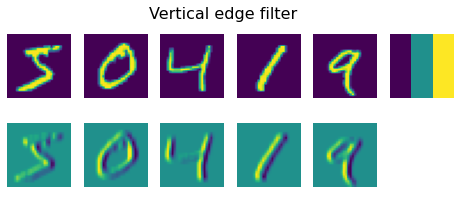

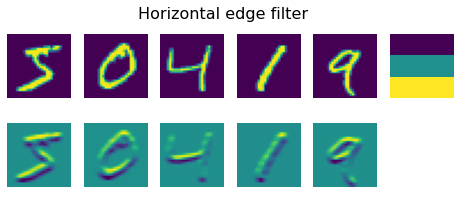

In [2]:
plot_convolution(x_train[:5],[[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]],'Vertical edge filter')
plot_convolution(x_train[:5],[[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]],'Horizontal edge filter')

First filter is called a **vertical edge filter**, and it is defined by the following matrix:
$$
\left(
    \begin{matrix}
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
    \end{matrix}
\right)
$$
When this filter goes over relatively uniform pixel field, all values add up to 0. When it encounters a vertical edge in the image, high spiked value is generated. That's why in the images above you can see vertical edges represented by high and low values, while horizontal edges are averaged out.

An opposite thing happens when we apply horizontal edge filter - horizontal lines are amplified, and vertical are averaged out.

In classical computer vision, multiple filters were applied to the image to generate features, which then were used by machine learning algorithm to build a classifier. In deep learning we construct networks that **learn** the best convolutional filters to solve classification problem on its own.

To do that, we introduce **convolutional layers**.

## Convolutional layers

Convolutional layers are defined using `Conv2d` class. We need to specify the following:
* `filters` - number of filters to use. We will use 9 different filters, which will give the network plenty of opportunities to explore which filters work best for our scenario.
* `kernel_size` is the size of the sliding window. Usually 3x3 or 5x5 filters are used.

The simplest CNN will contain only one convolutional layer. Given the input size 28x28, after applying nine 5x5 filters we will end up with a tensor of 24x24x9. The spatial dimension is smaller, because there are only 24 positions where a sliding interval of length 5 can fit into 28 pixels.

After the convolution layer, we flatten 24x24x9 tensor into one vector size of 5184. Then add the linear layer to produce 10 classes and use `relu` activation function in between layers. 

In [3]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=9, kernel_size=(5,5), input_shape=(28,28,1),activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 9)         234       
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                51850     
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
_________________________________________________________________


You can see that this network contains around 50k trainable parameters, compared to around 80k in fully-connected multi-layered networks. Convolutional networks generalize better which allows us to achieve good results on smaller datasets.

> **Note**: In most of the practical cases, we want to apply convolutional layers to color images. Thus, `Conv2D` layer expects the input to be of the shape $W\times H\times C$, where $W$ and $H$ are width and height of the image, and $C$ is the number of color channels. For grayscale images, we need the same shape with $C=1$.

We need to reshape our data before starting training:

In [12]:
x_train_c = np.expand_dims(x_train,3)
x_test_c = np.expand_dims(x_test,3)
hist = model.fit(x_train_c,y_train,validation_data=(x_test_c,y_test),epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0315 - acc: 0.9903 - val_loss: 0.0358 - val_acc: 0.9894
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0282 - acc: 0.9909 - val_loss: 0.0343 - val_acc: 0.9891
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0267 - acc: 0.9920 - val_loss: 0.0379 - val_acc: 0.9891
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0253 - acc: 0.9924 - val_loss: 0.0309 - val_acc: 0.9918
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0239 - acc: 0.9930 - val_loss: 0.0341 - val_acc: 0.9896


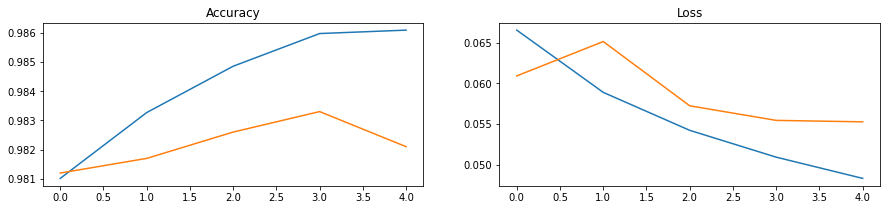

In [7]:
plot_results(hist)

As you can see, we are able to achieve higher accuracy with fewer epochs compared to the fully-connected networks from the previous unit. However, the training itself requires more resources, and may be slower on non-GPU computers.

## Visualizing Convolutional Layers

We can also visualize the weights of our trained convolutional layers to try and make some more sense of what is going on:

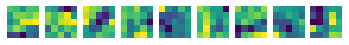

In [8]:
fig,ax = plt.subplots(1,9)
l = model.layers[0].weights[0]
for i in range(9):
    ax[i].imshow(l[...,0,i])
    ax[i].axis('off')

You can see that some of those filters look like they can recognize some oblique strokes, while others look pretty random. 

> **Task**: Train the same network with 3x3 filters and visualize them. Do you see more familiar patterns?

## Multi-layered CNNs and pooling layers

First the convolutional layers looks for primitive patterns, such as horizontal or vertical lines. We can apply further convolutional layers on top of them to look for higher-level patterns, such as primitive shapes. Then more convolutional layers can combine those shapes into some parts of the picture, up to the final object that we are trying to classify. 

When doing so, we may also apply one trick: reducing the spatial size of the image. Once we have detected there is a horizontal stoke within sliding 3x3 window, it is not so important at which exact pixel it occurred. Thus we can "scale down" the size of the image, which is done using one of the **pooling layers**:

 * **Average Pooling** takes a sliding window (for example, 2x2 pixels) and computes an average of values within the window
 * **Max Pooling** replaces the window with the maximum value. The idea behind max pooling is to detect a presence of a certain pattern within the sliding window.

Thus, in a typical CNN there would be several convolutional layers, with pooling layers in between them to decrease dimensions of the image. We would also increase the number of filters, because as patterns become more advanced - there are more possible interesting combinations that we need to be looking for.

![An image showing several convolutional layers with pooling layers.](notebooks/images/cnn-pyramid.png)

This architecture is also called **pyramid architecture** because of decreasing spatial dimensions and increasing feature/filters dimensions

In [9]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=10, kernel_size=(5,5), input_shape=(28,28,1),activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(filters=20, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPooling2D(),    
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 20)          5020      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3210      
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
____________________________________________________

Notice that the number of trainable parameters (~8.5K) is dramatically smaller than in the previous cases. This happens because convolutional layers in general have few parameters, and dimensionality of the image before applying final dense layer is significantly reduced.

In [11]:
hist = model.fit(x_train_c,y_train,validation_data=(x_test_c,y_test),epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0723 - acc: 0.9780 - val_loss: 0.0423 - val_acc: 0.9861
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0523 - acc: 0.9842 - val_loss: 0.0425 - val_acc: 0.9866
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0448 - acc: 0.9868 - val_loss: 0.0403 - val_acc: 0.9865
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0383 - acc: 0.9886 - val_loss: 0.0323 - val_acc: 0.9888
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0338 - acc: 0.9895 - val_loss: 0.0331 - val_acc: 0.9896


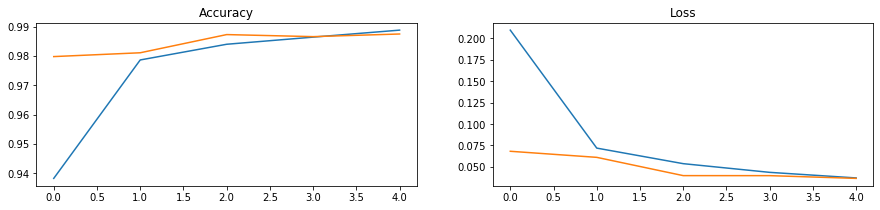

In [26]:
plot_results(hist)

Observe that we are able to achieve a higher accuracy with more than one layer, and it need a smaller number of epochs. It means that a more sophisticated network architecture less data to figure out what is going on, and to extract generic patterns from our images. However, training also takes longer and requires a GPU.

## Playing with real images from the CIFAR-10 dataset

While our handwritten digit recognition problem may seem like a toy problem, we are now ready to do something more serious. Let's explore a more advanced dataset of pictures of different objects, called [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). It contains 60k 32x32 images, divided into 10 classes. 

> When running in sandbox, we need to execute the following cell to pre-fetch CIFAR-10 dataset. You can skip the following cell if you are running the code from your own notebook.

In [ ]:
# Pre-fetch CIFAR-10 dataset when running in sandbox
!wget -P ~/.keras/datasets -q https://mslearntensorflowlp.blob.core.windows.net/data/cifar-10-batches-py.tar.gz

In [2]:
(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

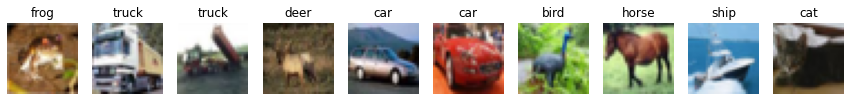

In [17]:
display_dataset(x_train,y_train,classes=classes)

A well-known architecture for CIFAR-10 is called [LeNet](https://en.wikipedia.org/wiki/LeNet), and has been proposed by *Yann LeCun*. It follows the same principles as we have outlined above, the main difference being 3 input color channels instead of 1. 

In [26]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,3)),
    keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    keras.layers.Conv2D(filters = 16, kernel_size = 5, strides = 1, activation = 'relu'),
    keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation = 'relu'),
    keras.layers.Dense(84, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax')])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_10 (Dense)             (None, 84)               

Training this network properly will a take significant amount of time and should be done on GPU-enabled compute.

In [27]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
hist = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6205 - acc: 0.4033 - val_loss: 1.4287 - val_acc: 0.4743
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3435 - acc: 0.5154 - val_loss: 1.2804 - val_acc: 0.5412
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.2225 - acc: 0.5645 - val_loss: 1.2164 - val_acc: 0.5600
Epoch 4/10
1563/1563 [==============================] - 5s 4ms/step - loss: 1.1360 - acc: 0.5957 - val_loss: 1.1918 - val_acc: 0.5768
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0776 - acc: 0.6178 - val_loss: 1.1451 - val_acc: 0.5906
Epoch 6/10
1563/1563 [==============================] - 5s 4ms/step - loss: 1.0228 - acc: 0.6370 - val_loss: 1.1178 - val_acc: 0.6098
Epoch 7/10
1563/1563 [==============================] - 5s 4ms/step - loss: 0.9769 - acc: 0.6544 - val_loss: 1.0793 - val_acc: 0.6202
Epoch 8/10
1563/1563 [==============================] - 5s 3ms

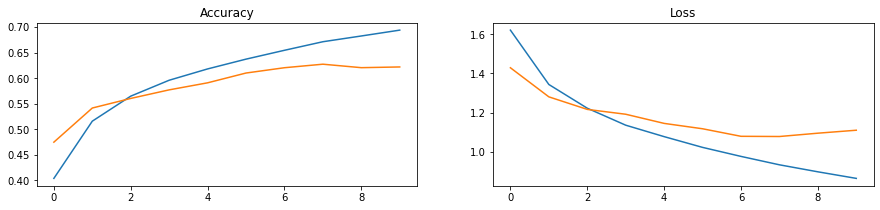

In [28]:
plot_results(hist)

The accuracy that we have been able to achieve with only a few epochs of training is just ok. Remember that our problem is actually significantly more difficult than MNIST digit classification. Getting above 50% accuracy is a good accomplishment in such a short training time.

## Takeaways

In this unit, we have learned the main concept behind computer vision neural networks - convolutional networks. Real-life architectures that power image classification, object detection, and even image generation networks are all based on CNNs, just with more layers and some additional training tricks.